# Clone Indonlu
Kita akan mengcopy github dari indonlu untuk menggunakan dataset NLP. Jadi dengan `!git clone` kita menarik semua file yang berada di githubnya.

In [1]:
!git clone https://github.com/indobenchmark/indonlu

fatal: destination path 'indonlu' already exists and is not an empty directory.


# Import Library

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D


You should consider upgrading via the 'C:\Users\gufra\Documents\Project\Belajar\ANPR with openCV_easyOCR\env\Scripts\python.exe -m pip install --upgrade pip' command.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gufra\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
data_train = pd.read_csv('indonlu/dataset/smsa_doc-sentiment-prosa/train_preprocess.tsv', sep='\t', names=["Teks", "Target"])
data_train.head()

,Teks,Target
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
2,lokasi strategis di jalan sumatera bandung . t...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative


Bisa di lihat di atas bahwa data kita memberikan nama kolom. Jadi kita punya 2 kolom yaitu `Teks` dan `Target`, data target mewakilkan apakah data teks tersebut Positif, Negatif, Netral.

# Labeling

In [4]:
# Labeling Label dataset
label_encoder = preprocessing.LabelEncoder()
data_train['Target'] = label_encoder.fit_transform(data_train['Target'])
data_train.head()

,Teks,Target
0,warung ini dimiliki oleh pengusaha pabrik tahu...,2
1,mohon ulama lurus dan k212 mmbri hujjah partai...,1
2,lokasi strategis di jalan sumatera bandung . t...,2
3,betapa bahagia nya diri ini saat unboxing pake...,2
4,duh . jadi mahasiswa jangan sombong dong . kas...,0


Setelah di sebelumnya Target betipa string, dengan kita labeling maka hasilnya akan berubah menjadi sebuah numeric. Tujuannya adalah agar mesin mengenali bahwa itu adalah data `Target` kita. 

* 0 = Negative
* 1 = Neutrtal
* 2 = Positive

# Split Data into Training and Test set

In [5]:
# # Split data into training and test sets
sentence = data_train['Teks'].values
target = data_train['Target'].values

sentence_train, sentence_test, target_train, target_test = train_test_split(sentence, target, test_size=0.1, shuffle=True, random_state=42)

# Change Label into Categorical
Sebelumnya kita sudah melakukan labeling pada data `Target` namun itu tidaklah cukup. Faktanya data target kita berupa Categorical, sehingga kita akan menjadikannya numeric categorical. Tensorflow juga menyediakan fungtion agar kita mudah melakukannya, dengan `to_categorical` kita bisa dengan mudah menjadikan data target kita menjadi Categorical.

In [6]:
target_train = to_categorical(target_train, num_classes=3)
target_test = to_categorical(target_test, num_classes=3)

# Tokenize
Sebelumnya kita tau bahwa mesin tidak bisa memproses text/string, oleh karena itu kita juga akan mengkonfersi setiap kata menjadi angka numerik. Salah satu caranya adalah dengan tokenisasi. Kita menggunakan tokenizer dari Tensorflow, untuk mengkonversikannya.

Konsepnya adalah kita akan memisahkan sebuah kalimat menjadi kata dan mempresentasikan sebuah kata tersebut menjadi numerik, contoh.<br />
"I Love my mother"  ==  [1, 2, 3, 4]
* I = 1
* Love = 2
* my = 3
* mother = 4

Kita juga akan menfilter simbol-simbol yang dapat mengganggu pada saat training seperti `!"#$%&()*+.,-/:;=?@[\]^_{|}~` <br />
Dan terakhir kita mengatasi kata-kata yang ambigu atau tidak mengerti apa artinya itu, dengan `<OOV>` kita merepresentasikan kata tersebut menjadi angka `1`, setelah ini kita akan melihatnya jadi langsung ajah.


In [7]:
# Tokenize
filt = '!"#$%&()*+.,-/:;=?@[\]^_`{|}~'
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>", filters=filt) # <OOV> untuk mengatasi kata yang tidak ada di vocab/tidak di ketahui
tokenizer.fit_on_texts(sentence_train) # Sequences
tokenizer.fit_on_texts(sentence_test) # Sequences

# Sequens and Padding
Sequense sebenarnya sudah kita lakukan pada code sebelumnya untuk melihat sequens (kalimat), oke tapi akan saya coba jelaskan.

**Sequence**: Merupakan kumpulan larik angka dari beberapa kata.<br/>
**Padding**: proses untuk membuat setiap kalimat pada teks memiliki panjang yang seragam.

Contoh:

=== **Sequence** ===

"Aku sayang ibu" == [1, 2, 3]<br/>
"Aku sayang kakak" == [1, 2, 4]<br/>
"Aku sayang ayah" == [1, 2, 5]

Larik angka tersebut di sebut dengan Sequence, jadi kita bisa simpulkan dengan bahasa kita sendiri bahwa sequence adalah larik angka dari beberapa kata yang sudah di tokenize.

=== **Padding** ===

"Aku sayang ibu" == [1, 2, 3]<br/>
"Aku sayang kakak" == [1, 2, 4]<br/>
"Aku sayang paman dan bibi" == [1, 2, 5, 6, 7]

dengan padding kita akan menyelaraskan larik tersebut, bisa dengan menyamakan panjang larik dari larik terpanjang, atau kita bisa menentukannya sendiri. Contoh kita kali ini akan menyamakan panjang larik dari larik yang terpanjang, maka akan menjadi seperti ini.

[1, 2, 3, 0, 0]<br/>
[1, 2, 4, 0, 0]<br/>
[1, 2, 5, 6, 7]

Karena kedua larik di atas mengikuti larik terpanjang, maka agar sama panjang ditambahlah angka `0` di sana. kita juga bisa menentukan angka nol tersebut mau di taruh depan atau di belakang sama seperti contoh di atas.

In [8]:
# membuat Sequens
train_sekuens = tokenizer.texts_to_sequences(sentence_train)
test_sekuens = tokenizer.texts_to_sequences(sentence_test)

# membuat padding
train_padded = pad_sequences(train_sekuens, padding='post', truncating='post')
test_padded = pad_sequences(test_sekuens, padding='post', truncating='post')

# Modeling
Kita akan menggunakan tensorflow untuk melakukan proses modeling, dengan memanfaatkan Sequential kita dengan mudah akan mengatur Embedding, dan layar Dense, kita juga menggunakan GlobalAverangePooling1D.

In [9]:
# membuat model
model = Sequential([
    tf.keras.layers.Embedding(10000, 150),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [10]:
# compile model
model.compile(optimizer='RMSprop', 
            loss='categorical_crossentropy',
            metrics=['accuracy'])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 150)         1500000   
                                                                 
 global_average_pooling1d (G  (None, 150)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 10)                1510      
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 3)                 33        
                                                                 
Total params: 1,501,543
Trainable params: 1,501,543
Non-trainable params: 0
______________________________________________

Code di bawah adalah dimana proses training di mulai, kita menentukan epoch sebanyak `20`. Epoch adalah perulangan dalam proses latih, gampangnya seperti kita berlari 20 putaran di lapangan. Epoch 20 menurut saya sudah cukup bagus, karena sebelumnya saya sudah melatih lebih dari ini dan hasilnya tidak beda jauh, bahkan terkadang menjadi lebih buruk.

In [12]:
# Train model
num_epochs = 20
history = model.fit(train_padded, target_train,
                    epochs=num_epochs,
                    validation_data=(test_padded, target_test),
                    verbose=1)

Epoch 1/20
310/310 [==============================] - 4s 11ms/step - loss: 0.8053 - accuracy: 0.6425 - val_loss: 0.6475 - val_accuracy: 0.7418
Epoch 2/20
310/310 [==============================] - 3s 10ms/step - loss: 0.6097 - accuracy: 0.7611 - val_loss: 0.5600 - val_accuracy: 0.7700
Epoch 3/20
310/310 [==============================] - 3s 10ms/step - loss: 0.5243 - accuracy: 0.7774 - val_loss: 0.5094 - val_accuracy: 0.7782
Epoch 4/20
310/310 [==============================] - 3s 10ms/step - loss: 0.4651 - accuracy: 0.8078 - val_loss: 0.4553 - val_accuracy: 0.8355
Epoch 5/20
310/310 [==============================] - 3s 11ms/step - loss: 0.4205 - accuracy: 0.8401 - val_loss: 0.4228 - val_accuracy: 0.8464
Epoch 6/20
310/310 [==============================] - 3s 11ms/step - loss: 0.3929 - accuracy: 0.8540 - val_loss: 0.4108 - val_accuracy: 0.8536
Epoch 7/20
310/310 [==============================] - 3s 11ms/step - loss: 0.3601 - accuracy: 0.8680 - val_loss: 0.3904 - val_accuracy: 0.8727

# Visualization of Training Results
Tahap ini kita akan melihat hasil training kita dengan visualisasi agar mudah di pahami.

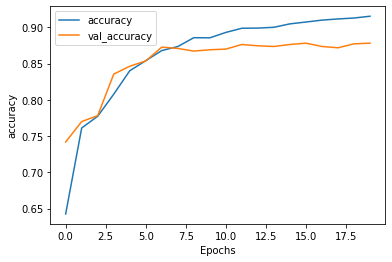

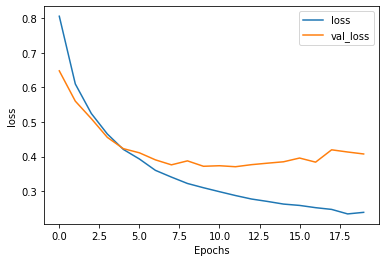

In [16]:
# visualisasi training

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

# Save Model

In [13]:
model.save("model")

INFO:tensorflow:Assets written to: model\assets


# Load Model

In [14]:
new_model = tf.keras.models.load_model('model')
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 150)         1500000   
                                                                 
 global_average_pooling1d (G  (None, 150)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 10)                1510      
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 3)                 33        
                                                                 
Total params: 1,501,543
Trainable params: 1,501,543
Non-trainable params: 0
______________________________________________

# Testing Model
* [1, 0, 0] = Negative
* [0, 1, 0] = Neutrral
* [0, 0, 1] = Positve

Di atas adalah representasi label kita setelah di lakukan `to_categorical`, kita akan mencoba dengan kalimat yang kita buat sendiri, apakah kalimat tersebut Positive, Negatif, Neutral.

In [20]:
# Testing Model
teks = ["awalnya aku menyukainya, namun setelah kesini aku rasa dia bukan orang yang asik",
        "Aku rasa dia orang yang hebat, dia bisa menciptakan apa yang orang lain tidak bisa. Keren.",
        "Mohon di luruskan dan di rapatkan barisan nya."]
teks_token = tokenizer.texts_to_sequences(teks)
teks_padded = pad_sequences(teks_token, maxlen=100, padding='post', truncating='post')
print(np.rint(new_model.predict(teks_padded)))

[[1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]]


Dari hasil di atas kita bisa simpulkan bahwa,<br/>
* "awalnya aku menyukainya, namun setelah kesini aku rasa dia bukan orang yang asik" = **Negative**
* "Aku rasa dia orang yang hebat, dia bisa menciptakan apa yang orang lain tidak bisa. Keren." = **Positive**
* "Mohon di luruskan dan di rapatkan barisan nya." = **Neutral**

Jadi kita telah berhasil dan selesai membuat Sentiment Analysis menggunakan Tensorflow, di bantu dengan dataset dari indonlu.